In [1]:
import pandas as pd
import numpy as np

In [2]:
data = pd.read_csv("CreditScoring.csv")
data.head()

,Status,Seniority,Home,Time,Age,Marital,Records,Job,Expenses,Income,Assets,Debt,Amount,Price
0,1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,1,0,1,36,26,1,1,1,46,107,0,0,310,910


#### Data Cleaning

In [3]:
data.columns = data.columns.str.lower()

In [4]:
data.isnull().sum()

status       0
seniority    0
home         0
time         0
age          0
marital      0
records      0
job          0
expenses     0
income       0
assets       0
debt         0
amount       0
price        0
dtype: int64

In [5]:
for column in ["status", "home", "marital", "records", "job"]:
    print(data[column].value_counts())

status
1    3200
2    1254
0       1
Name: count, dtype: int64
home
2    2107
1     973
5     783
6     319
3     247
4      20
0       6
Name: count, dtype: int64
marital
2    3241
1     978
4     130
3      67
5      38
0       1
Name: count, dtype: int64
records
1    3682
2     773
Name: count, dtype: int64
job
1    2806
3    1024
2     452
4     171
0       2
Name: count, dtype: int64


In [6]:
values = {
    "status": {
        1: 'ok',
        2: 'default',
        0: 'unknown'
    },
    "home": {
        1: "rent",
        2: "owner",
        3: "priv",
        4: "ignore",
        5: "parents",
        6: "other",
        0: "unknown"
    },
    "marital": {
        1: "single",
        2: "married",
        3: "widow",
        4: "separated",
        5: "divorced",
        0: "unknown"
    },
    "records": {
        1: "no",
        2: "yes",
        0: "unknown"
    },
    "job": {
        1: "fixed",
        2: "partime",
        3: "freelance",
        4: "others",
        0: "unknown"
    }
}

In [7]:
for key, value in values.items():
    data[key] = data[key].map(value)

In [8]:
data.head(2)

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,ok,9,rent,60,30,married,no,freelance,73,129,0,0,800,846
1,ok,17,rent,60,58,widow,no,fixed,48,131,0,0,1000,1658


In [9]:
data.describe().round()

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0
mean,8.0,46.0,37.0,56.0,763317.0,1060341.0,404382.0,1039.0,1463.0
std,8.0,15.0,11.0,20.0,8703625.0,10217569.0,6344253.0,475.0,628.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1118.0
50%,5.0,48.0,36.0,51.0,120.0,3500.0,0.0,1000.0,1400.0
75%,12.0,60.0,45.0,72.0,166.0,6000.0,0.0,1300.0,1692.0
max,48.0,72.0,68.0,180.0,99999999.0,99999999.0,99999999.0,5000.0,11140.0


In [10]:
# 99999999.0 are zeros and we will replace them with nan
for col in ["income", "assets", "debt"]:
    data[col] = data[col].replace(99999999.0, np.nan)

In [11]:
data = data[data['status'] != 'unknown'].reset_index(drop=True)

In [12]:
from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(data, test_size=0.2, random_state=11)
df_train, df_val = train_test_split(data, test_size=0.25, random_state=11)

In [13]:
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)

y_train = df_train.pop('status')
y_test = df_test.pop('status')
y_val = df_val.pop('status')

y_train = (y_train == 'default').astype('int').values
y_test = (y_test == 'default').astype('int').values
y_val = (y_val == 'default').astype('int').values

In [14]:
# dfs = [df_train, df_test, df_val]
# ys = []

# for df in dfs:
#     df.reset_index(drop=True)
#     y = df.pop('status')
#     y = (y == 'default').astype('int').values
#     ys.append(y)

# y_train, y_test, y_val = ys

In [15]:
df_train.shape, df_val.shape, df_test.shape

((3340, 13), (1114, 13), (891, 13))

#### Decision trees

In [16]:
df_train.iloc[0].to_dict()

{'seniority': 1,
 'home': 'rent',
 'time': 36,
 'age': 24,
 'marital': 'married',
 'records': 'no',
 'job': 'partime',
 'expenses': 41,
 'income': 56.0,
 'assets': 0.0,
 'debt': 0.0,
 'amount': 500,
 'price': 585}

In [17]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import DecisionTreeClassifier

In [18]:
train_dicts = df_train.fillna(0).to_dict(orient='records')
dv = DictVectorizer(sparse=True)
X_train = dv.fit_transform(train_dicts)

In [19]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

DecisionTreeClassifier()

In [20]:
val_dicts = df_val.fillna(0).to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [21]:
y_val_pred = dt.predict(X_val)

In [22]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_val_pred, y_val)

0.6377860882572924

In [23]:
from sklearn.metrics import roc_auc_score
y_train_pred = dt.predict(X_train)
roc_auc_score(y_train, y_train_pred)

1.0

In [24]:
# This is a case of overfitting due to the depth of the tree
# Let's train another tree with smaller depth

dt = DecisionTreeClassifier(max_depth=2)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=2)

In [25]:
y_train_pred = dt.predict_proba(X_train)[:, 1]
auc_train_score = roc_auc_score(y_train, y_train_pred)

y_val_pred = dt.predict_proba(X_val)[:, 1]
auc_val_score = roc_auc_score(y_val, y_val_pred)

display(auc_train_score, auc_val_score)

0.6972613817060012

0.6624278637454675

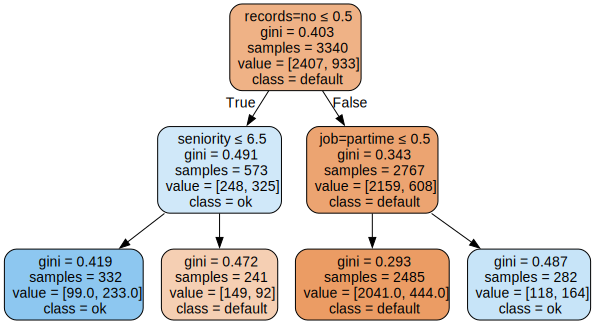

In [26]:
from sklearn.tree import export_graphviz
import matplotlib.pyplot as plt
%matplotlib inline
import graphviz


dot_data = export_graphviz(dt, out_file=None, feature_names=dv.get_feature_names_out(), class_names=['default', 'ok'], filled=True, rounded=True, special_characters=True)
graph = graphviz.Source(dot_data)
graph.render("decision_tree") # Save as file graph
graph

In [ ]:
from sklearn.tree import export_text

print(export_text(dt, feature_names=dv.get_feature_names_out()))

|--- records=no <= 0.50
|   |--- seniority <= 6.50
|   |   |--- class: 1
|   |--- seniority >  6.50
|   |   |--- class: 0
|--- records=no >  0.50
|   |--- job=partime <= 0.50
|   |   |--- class: 0
|   |--- job=partime >  0.50
|   |   |--- class: 1



#### Decision Tree Learning Algorithm

* Finding the best split for one column
* Finding the best split for the entire dataset
* Stopping criteria
* Decision tree learning algorithm

In [28]:
data = [
    [8000, "default"],
    [2000, "default"],
    [0, "default"],
    [5000, "ok"],
    [5000, "ok"],
    [4000, "ok"],
    [9000, "ok"],
    [3000, "default"],
]
df_example = pd.DataFrame(data, columns=["amount", "status"])

In [29]:
df_example.sort_values("amount")

,amount,status
2,0,default
1,2000,default
7,3000,default
5,4000,ok
3,5000,ok
4,5000,ok
0,8000,default
6,9000,ok


In [30]:
Ts = [0, 2000, 3000, 4000, 5000, 8000]

for T in Ts:
    df_left = df_example[df_example.amount <= T]
    df_right = df_example[df_example.amount > T]

    print(f"left hand side of {T} \n{df_left.status.value_counts(normalize=True)}")
    display(df_left)
    print(f"right hand side of {T} \n{df_right.status.value_counts(normalize=True)}")
    display(df_right)

    print()

left hand side of 0 
status
default    1.0
Name: proportion, dtype: float64


,amount,status
2,0,default


right hand side of 0 
status
ok         0.571429
default    0.428571
Name: proportion, dtype: float64


,amount,status
0,8000,default
1,2000,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok
7,3000,default



left hand side of 2000 
status
default    1.0
Name: proportion, dtype: float64


,amount,status
1,2000,default
2,0,default


right hand side of 2000 
status
ok         0.666667
default    0.333333
Name: proportion, dtype: float64


,amount,status
0,8000,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok
7,3000,default



left hand side of 3000 
status
default    1.0
Name: proportion, dtype: float64


,amount,status
1,2000,default
2,0,default
7,3000,default


right hand side of 3000 
status
ok         0.8
default    0.2
Name: proportion, dtype: float64


,amount,status
0,8000,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok



left hand side of 4000 
status
default    0.75
ok         0.25
Name: proportion, dtype: float64


,amount,status
1,2000,default
2,0,default
5,4000,ok
7,3000,default


right hand side of 4000 
status
ok         0.75
default    0.25
Name: proportion, dtype: float64


,amount,status
0,8000,default
3,5000,ok
4,5000,ok
6,9000,ok



left hand side of 5000 
status
default    0.5
ok         0.5
Name: proportion, dtype: float64


,amount,status
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
5,4000,ok
7,3000,default


right hand side of 5000 
status
default    0.5
ok         0.5
Name: proportion, dtype: float64


,amount,status
0,8000,default
6,9000,ok



left hand side of 8000 
status
default    0.571429
ok         0.428571
Name: proportion, dtype: float64


,amount,status
0,8000,default
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
5,4000,ok
7,3000,default


right hand side of 8000 
status
ok    1.0
Name: proportion, dtype: float64


,amount,status
6,9000,ok


In [31]:
data = [
    [8000, 3000, "default"],
    [2000, 1000, "default"],
    [0, 1000, "default"],
    [5000, 1000, "ok"],
    [5000, 1000, "ok"],
    [4000, 1000, "ok"],
    [9000, 500, "ok"],
    [3000, 2000, "default"],
]
df_example1 = pd.DataFrame(data, columns=["amount", "debt", "status"])

In [32]:
df_example1.sort_values('debt')

,amount,debt,status
6,9000,500,ok
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
7,3000,2000,default
0,8000,3000,default


In [33]:
thresholds = {
    'amount': [0, 2000, 3000, 4000, 5000, 8000],
    'debt': [500, 1000, 2000]
}

In [34]:
for feature, Ts in thresholds.items():
    print("#######")
    print(feature)
    for T in Ts:
        print(T)
        df_left = df_example1[df_example1[feature] <= T]
        df_right = df_example1[df_example1[feature] > T]
    
        print(f"left hand side of {T} \n{df_left.status.value_counts(normalize=True)}")
        display(df_left)
        print(f"right hand side of {T} \n{df_right.status.value_counts(normalize=True)}")
        display(df_right)
    
        print() 

#######
amount
0
left hand side of 0 
status
default    1.0
Name: proportion, dtype: float64


,amount,debt,status
2,0,1000,default


right hand side of 0 
status
ok         0.571429
default    0.428571
Name: proportion, dtype: float64


,amount,debt,status
0,8000,3000,default
1,2000,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default



2000
left hand side of 2000 
status
default    1.0
Name: proportion, dtype: float64


,amount,debt,status
1,2000,1000,default
2,0,1000,default


right hand side of 2000 
status
ok         0.666667
default    0.333333
Name: proportion, dtype: float64


,amount,debt,status
0,8000,3000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default



3000
left hand side of 3000 
status
default    1.0
Name: proportion, dtype: float64


,amount,debt,status
1,2000,1000,default
2,0,1000,default
7,3000,2000,default


right hand side of 3000 
status
ok         0.8
default    0.2
Name: proportion, dtype: float64


,amount,debt,status
0,8000,3000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok



4000
left hand side of 4000 
status
default    0.75
ok         0.25
Name: proportion, dtype: float64


,amount,debt,status
1,2000,1000,default
2,0,1000,default
5,4000,1000,ok
7,3000,2000,default


right hand side of 4000 
status
ok         0.75
default    0.25
Name: proportion, dtype: float64


,amount,debt,status
0,8000,3000,default
3,5000,1000,ok
4,5000,1000,ok
6,9000,500,ok



5000
left hand side of 5000 
status
default    0.5
ok         0.5
Name: proportion, dtype: float64


,amount,debt,status
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
7,3000,2000,default


right hand side of 5000 
status
default    0.5
ok         0.5
Name: proportion, dtype: float64


,amount,debt,status
0,8000,3000,default
6,9000,500,ok



8000
left hand side of 8000 
status
default    0.571429
ok         0.428571
Name: proportion, dtype: float64


,amount,debt,status
0,8000,3000,default
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
7,3000,2000,default


right hand side of 8000 
status
ok    1.0
Name: proportion, dtype: float64


,amount,debt,status
6,9000,500,ok



#######
debt
500
left hand side of 500 
status
ok    1.0
Name: proportion, dtype: float64


,amount,debt,status
6,9000,500,ok


right hand side of 500 
status
default    0.571429
ok         0.428571
Name: proportion, dtype: float64


,amount,debt,status
0,8000,3000,default
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
7,3000,2000,default



1000
left hand side of 1000 
status
ok         0.666667
default    0.333333
Name: proportion, dtype: float64


,amount,debt,status
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok


right hand side of 1000 
status
default    1.0
Name: proportion, dtype: float64


,amount,debt,status
0,8000,3000,default
7,3000,2000,default



2000
left hand side of 2000 
status
ok         0.571429
default    0.428571
Name: proportion, dtype: float64


,amount,debt,status
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


right hand side of 2000 
status
default    1.0
Name: proportion, dtype: float64


,amount,debt,status
0,8000,3000,default


##### Stopping criteria to stop splitting the tree

* Group already pure (0% impurity)
* Tree reached depth limit
* Group too small to split

##### Decision Tree Learning Algorithm

* Find the best split
* Stop if Max_depth is reached
* If left is sufficiently large and not pure
    * Repeat for left
* If right is sufficiently large and not pure
    * Repeat for right

#### Decision Trees Parameter Tuning

* Selecting max_depth
* selecting min_samples_leaf

In [35]:
from sklearn.metrics import roc_auc_score
for d in [1, 2, 3, 4, 5, 6, 10, 15, 20, None]:
    dt = DecisionTreeClassifier(max_depth = d)
    dt.fit(X_train, y_train)

    y_pred = dt.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)

    print(f"{d} -> {auc:.3f}")

1 -> 0.601
2 -> 0.662
3 -> 0.740
4 -> 0.780
5 -> 0.781
6 -> 0.781
10 -> 0.680
15 -> 0.654
20 -> 0.666
None -> 0.648


In [36]:
scores = []
for d in [4, 5, 6, 7, 10, 15, 20, None]:
    for s in [1, 2, 5, 10, 15, 20, 100, 200, 500]:
        dt = DecisionTreeClassifier(max_depth = d, min_samples_leaf=s)
        dt.fit(X_train, y_train)

        y_pred = dt.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        scores.append((d, s, auc))

In [37]:
df_scores = pd.DataFrame(scores, columns= ["max_depth", "min_samples_leaf", "auc"])

In [38]:
df_scores.sort_values('auc', ascending=False).head()

,max_depth,min_samples_leaf,auc
33,7.0,100,0.792147
51,15.0,100,0.791389
60,20.0,100,0.791389
42,10.0,100,0.791389
69,NaN,100,0.791389


In [39]:
df_scores_pivot = df_scores.pivot(index='min_samples_leaf', columns='max_depth',
                values=['auc']).round(3)
df_scores_pivot

auc                                                 
max_depth           NaN   4.0    5.0    6.0    7.0    10.0   15.0   20.0
min_samples_leaf                                                        
1                 0.656  0.780  0.782  0.780  0.752  0.684  0.652  0.664
2                 0.667  0.781  0.783  0.783  0.756  0.692  0.676  0.667
5                 0.720  0.779  0.783  0.780  0.768  0.723  0.718  0.714
10                0.754  0.779  0.783  0.776  0.776  0.746  0.755  0.752
15                0.769  0.779  0.782  0.779  0.777  0.769  0.769  0.772
20                0.783  0.776  0.781  0.784  0.786  0.788  0.776  0.777
100               0.791  0.770  0.779  0.788  0.792  0.791  0.791  0.791
200               0.783  0.770  0.783  0.783  0.783  0.783  0.783  0.783
500               0.729  0.729  0.729  0.729  0.729  0.729  0.729  0.729

<Axes: xlabel='None-max_depth', ylabel='min_samples_leaf'>

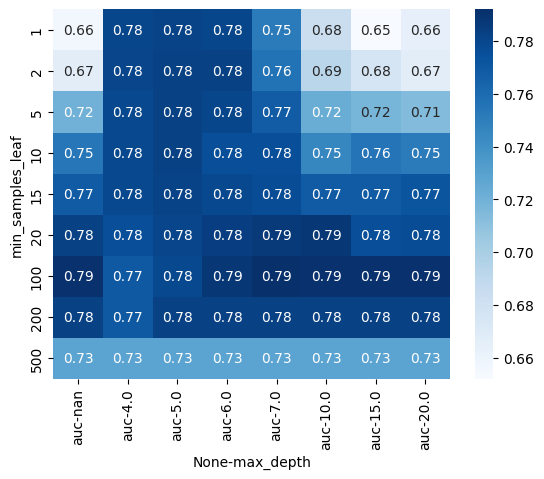

In [40]:
import seaborn as sns
sns.heatmap(df_scores_pivot, annot=True, cmap='Blues', fmt='.2f')

In [41]:
dt = DecisionTreeClassifier(max_depth=5, min_samples_leaf=10)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, min_samples_leaf=10)

In [42]:
print(export_text(dt, feature_names=list(dv.feature_names_)))

|--- records=no <= 0.50
|   |--- seniority <= 6.50
|   |   |--- seniority <= 1.50
|   |   |   |--- assets <= 4750.00
|   |   |   |   |--- income <= 80.50
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- income >  80.50
|   |   |   |   |   |--- class: 1
|   |   |   |--- assets >  4750.00
|   |   |   |   |--- job=fixed <= 0.50
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- job=fixed >  0.50
|   |   |   |   |   |--- class: 0
|   |   |--- seniority >  1.50
|   |   |   |--- amount <= 939.50
|   |   |   |   |--- price <= 947.50
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- price >  947.50
|   |   |   |   |   |--- class: 0
|   |   |   |--- amount >  939.50
|   |   |   |   |--- assets <= 8250.00
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- assets >  8250.00
|   |   |   |   |   |--- class: 0
|   |--- seniority >  6.50
|   |   |--- income <= 109.50
|   |   |   |--- assets <= 4500.00
|   |   |   |   |--- income <= 68.00
|   |   |   |   |   |--- class: 1
|   |   | 

#### Ensemble Learning and Random Forest

* Board of experts
* Ensembling models
* Random Forest - ensembling decision trees
* Tuning random forest

In [43]:
from sklearn.ensemble import RandomForestClassifier

In [44]:
rf = RandomForestClassifier(n_estimators=10)
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=10)

In [45]:
from sklearn.metrics import roc_auc_score
y_pred = rf.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.7746579297827958

In [46]:
# import tracemalloc

# scores = []
# memory_read = {
#     'current_memory': [],
#     'peak_memory': []
# }

# for n in range(10, 201, 10):
#     tracemalloc.start()
#     rf = RandomForestClassifier(n_estimators=n, random_state=1)
#     rf.fit(X_train, y_train)

#     y_pred = rf.predict_proba(X_val)[:, 1]
#     auc = roc_auc_score(y_val, y_pred)
#     current, peak = tracemalloc.get_traced_memory()
#     memory_read['current_memory'].append(current)
#     memory_read['peak_memory'].append(peak)
#     scores.append((n, auc))

In [47]:
import tracemalloc
import pandas as pd
from sklearn.ensemble import RandomForestClassifier

# Initialize lists for scores and memory readings
scores = []
memory_read = {
    'current_memory': [],
    'peak_memory': []
}

for n in range(10, 201, 10):
    tracemalloc.start()
    
    # Fit the RandomForest model
    rf = RandomForestClassifier(n_estimators=n, random_state=1)
    rf.fit(X_train, y_train)
    
    # Predict and calculate AUC
    y_pred = rf.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    
    # Track memory usage
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    
    memory_read['current_memory'].append(current)
    memory_read['peak_memory'].append(peak)
    scores.append((n, auc))

In [48]:
results = pd.DataFrame({
    'models': [n for n, _ in scores],
    'roc_auc_score': [auc for _, auc in scores],
    'current_memory': memory_read['current_memory'],
    'peak_memory': memory_read['peak_memory']
})

results.sort_values(by='roc_auc_score', ascending=False)

,models,roc_auc_score,current_memory,peak_memory
16,170,0.830723,140993,872849
14,150,0.830475,128303,872849
15,160,0.830456,137181,872849
18,190,0.830387,156549,872849
17,180,0.830088,146809,872849
19,200,0.830051,159059,872849
13,140,0.830014,122002,872849
12,130,0.829584,115948,872849
11,120,0.829303,109762,872849
10,110,0.828527,103525,872849


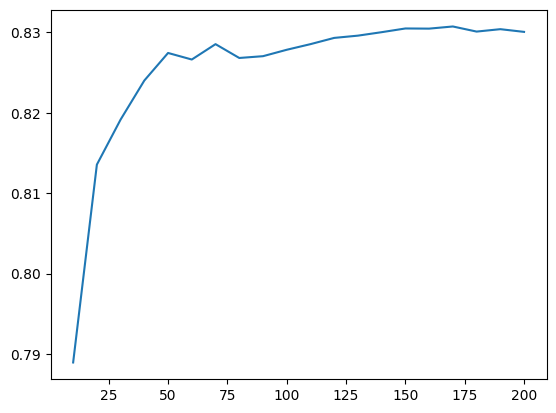

In [49]:
plt.plot(results.models, results.roc_auc_score)

In [50]:
# Adding max_depth to our model
scores = []

for d in [5, 10, 15]:
    for n in range(10, 201, 10):
        
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=d,
                                    random_state=1)
        rf.fit(X_train, y_train)
        
        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        scores.append((d, n, auc))

In [51]:
columns = ["max_depth", "n_estimators", "auc"]
df_scores = pd.DataFrame(scores, columns=columns)
df_scores.head()

,max_depth,n_estimators,auc
0,5,10,0.819097
1,5,20,0.822416
2,5,30,0.826779
3,5,40,0.824382
4,5,50,0.825887


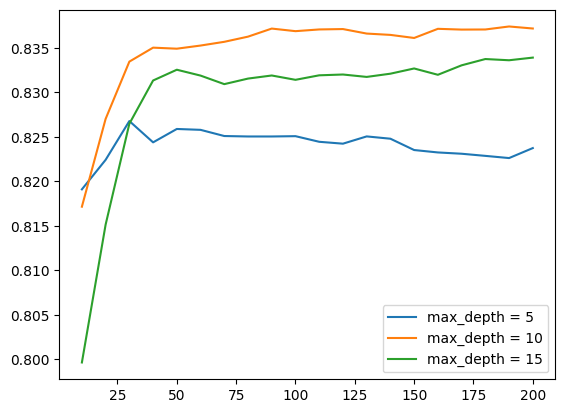

In [52]:
for d in [5, 10, 15]:
    df_subset = df_scores[df_scores.max_depth == d]
    plt.plot(df_subset.n_estimators, df_subset.auc, label=f"max_depth = {d}")

plt.legend()
plt.show()

In [53]:
max_depth = 10
scores = []

for s in [1, 3, 5, 10, 50]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=max_depth,
                                    min_samples_leaf=s,
                                    random_state=1)
        rf.fit(X_train, y_train)
        
        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        scores.append((s, n, auc))

In [54]:
columns = ["min_samples_leaf", "n_estimators", "auc"]
df_scores = pd.DataFrame(scores, columns=columns)
df_scores.sort_values(by="auc", ascending=False).head()

,min_samples_leaf,n_estimators,auc
61,10,20,0.838218
18,1,190,0.837413
19,1,200,0.837185
8,1,90,0.837177
15,1,160,0.837150


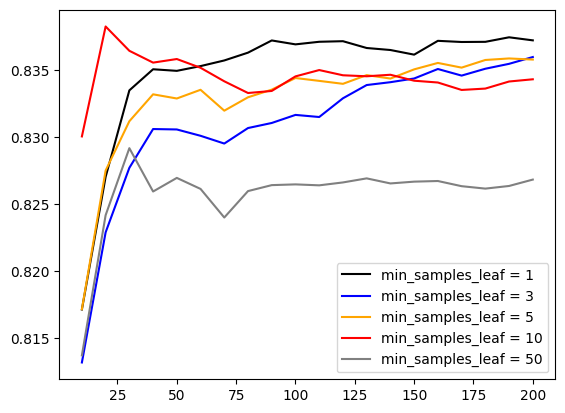

In [55]:
colors = ['black', 'blue', 'orange', 'red', 'grey']
min_sample_leaf = [1, 3, 5, 10, 50]
for s, color in zip(min_sample_leaf, colors):
    df_subset = df_scores[df_scores.min_samples_leaf == s]
    plt.plot(df_subset.n_estimators, df_subset.auc,
             color=color,
             label=f"min_samples_leaf = {s}")

plt.legend()
plt.show()

In [56]:
min_sample_leaf = 10

rf = RandomForestClassifier(n_estimators=50,
                            max_depth=max_depth,
                            min_samples_leaf=min_sample_leaf,
                            random_state=1,
                            n_jobs=2)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=10, n_estimators=50,
                       n_jobs=2, random_state=1)

#### Gradient Boosting and XGBoost

In [57]:
import xgboost as xgb

In [58]:
features = dv.feature_names_
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features) 

In [59]:
xgb_params = {
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,
    'objective': 'binary:logistic',
    'nthread': 4,

    'seed': 1,
    'verbosity': 1
}

model = xgb.train(xgb_params, dtrain, num_boost_round=10)

In [60]:
y_pred = model.predict(dval)
roc_auc_score(y_val, y_pred)

0.8275918963830715

In [61]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [62]:
from io import StringIO
import contextlib

In [63]:
xgb_params = {
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'nthread': 4,
    'eval_metric': 'auc',

    'seed': 1,
    'verbosity': 1
}

with contextlib.redirect_stdout(StringIO()) as f:
    model = xgb.train(xgb_params,
                      dtrain,
                      num_boost_round=200,
                      evals=watchlist,
                      verbose_eval=10)
    output = f.getvalue()

In [64]:
import pandas as pd
def parse_xgb_output(output:str)->pd.DataFrame:
    """
    Parse the output of an XGBoost training run.

    Args:
        output (str): The output of the XGBoost training run.

    Returns:
        dataframe: A pandas dataframe containing the parsed output.
    """
    results = []

    for line in output.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        iteration = it_line.strip('[]')
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((iteration, train, val))

    columns = ['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns=columns)

    return df_results

In [65]:
df_score = parse_xgb_output(output)
df_score.head()

,num_iter,train_auc,val_auc
0,0,0.84467,0.79010
1,10,0.93977,0.82762
2,20,0.96525,0.83016
3,30,0.97949,0.82510
4,40,0.98623,0.82223


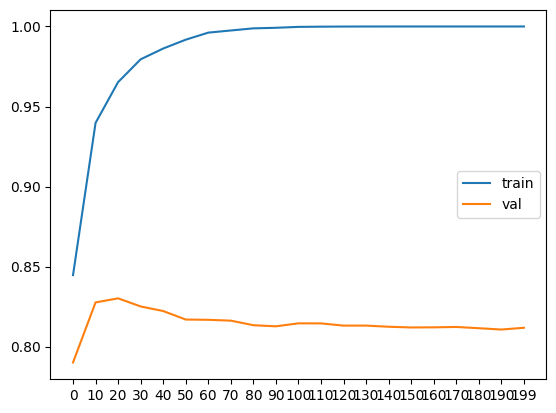

In [66]:
plt.plot(df_score.num_iter, df_score.train_auc, label='train')
plt.plot(df_score.num_iter, df_score.val_auc, label='val')
plt.legend()
plt.show()

#### XGBoost Parameter Tuning

1. ETA (Learning Rate) = Size of step
2. Max_depth
3. Min_child_weight (same as min_samples_leaf in Random Forest)

In [67]:
scores = {}
for i in ["0.01", "0.05", "0.1", "0.3", "1.0"]:
    xgb_params = {
        'eta': float(i),
        'max_depth': 6,
        'min_child_weight': 1,
        'objective': 'binary:logistic',
        'nthread': 4,
        'eval_metric': 'auc',
        'seed': 1,
        'verbosity': 1
    }
    
    # Use StringIO to capture the output of xgb.train
    with contextlib.redirect_stdout(StringIO()) as f:
        model = xgb.train(xgb_params, dtrain, num_boost_round=200, evals=watchlist, verbose_eval=5)
        output = f.getvalue()
    
    key = f"eta={xgb_params['eta']}"
    scores[key] = parse_xgb_output(output)


In [68]:
scores['eta=1.0'][:5]

,num_iter,train_auc,val_auc
0,0,0.84467,0.79010
1,5,0.94353,0.79061
2,10,0.97485,0.77840
3,15,0.99079,0.77213
4,20,0.99803,0.77094


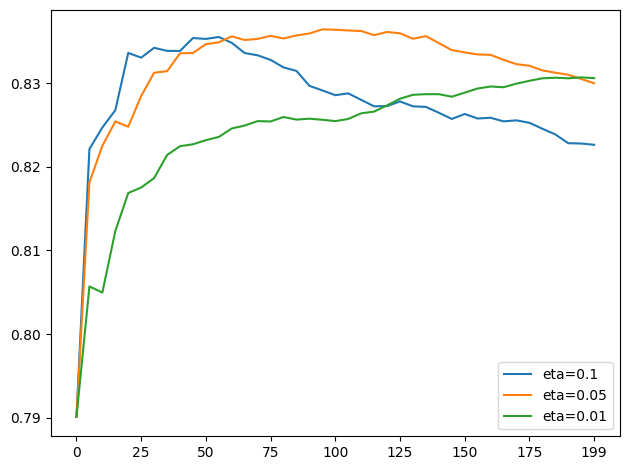

In [69]:
etas = ["eta=0.1", "eta=0.05", "eta=0.01"]

for eta in etas:
    values = scores[eta]
    plt.plot(values.num_iter, values.val_auc, label=eta)
plt.legend()
plt.tight_layout()
ax = plt.gca()  # get current axis
ax.xaxis.set_major_locator(plt.MaxNLocator(10))
plt.show()

0.1 eta seems to be the best learning rate for our model

Max_depth

In [70]:
scores = {}
for i in ["3", "4", "6", "10"]:
    xgb_params = {
        'eta': 0.1,
        'max_depth': int(i),
        'min_child_weight': 1,
        'objective': 'binary:logistic',
        'nthread': 4,
        'eval_metric': 'auc',
        'seed': 1,
        'verbosity': 1
    }
    
    # Use StringIO to capture the output of xgb.train
    with contextlib.redirect_stdout(StringIO()) as f:
        model = xgb.train(xgb_params, dtrain, num_boost_round=200, evals=watchlist, verbose_eval=5)
        output = f.getvalue()
    
    key = f"max_depth={xgb_params['max_depth']}"
    scores[key] = parse_xgb_output(output)


In [71]:
del scores['max_depth=10']

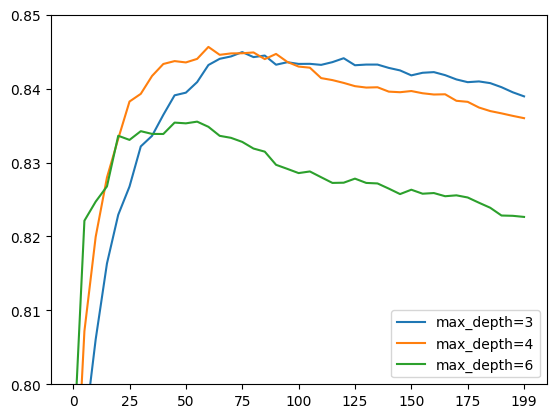

In [72]:
for max_depth, values in scores.items():
    plt.plot(values.num_iter, values.val_auc, label=max_depth)
plt.ylim(0.8, 0.85)
plt.legend()
ax = plt.gca()  # get current axis
ax.xaxis.set_major_locator(plt.MaxNLocator(10))

4 seems to be the best max_depth for our model

In [73]:
scores = {}
for i in ["1", "10", "30"]:
    xgb_params = {
        'eta': 0.1,
        'max_depth': 4,
        'min_child_weight': int(i),
        'objective': 'binary:logistic',
        'nthread': 4,
        'eval_metric': 'auc',
        'seed': 1,
        'verbosity': 1
    }
    
    # Use StringIO to capture the output of xgb.train
    with contextlib.redirect_stdout(StringIO()) as f:
        model = xgb.train(xgb_params, dtrain, num_boost_round=200, evals=watchlist, verbose_eval=5)
        output = f.getvalue()
    
    key = f"min_child_weight={xgb_params['min_child_weight']}"
    scores[key] = parse_xgb_output(output)


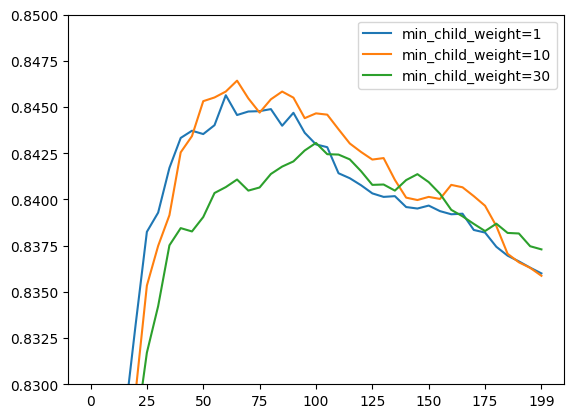

In [74]:
for min_child_weight, values in scores.items():
    plt.plot(values.num_iter, values.val_auc, label=min_child_weight)
plt.ylim(0.83, 0.85)
plt.legend()
ax = plt.gca()  # get current axis
ax.xaxis.set_major_locator(plt.MaxNLocator(10))

final_model 

In [99]:
# min_child_weight = ["1", "10", "30"]
# max_depth = ["3", "4", "6", "10"]
# eta = ["0.01", "0.05", "0.1", "0.3", "1.0"]

In [98]:
# from sklearn.model_selection import RandomizedSearchCV
# import warnings
# warnings.filterwarnings('ignore')


# param_distributions = {
#     'eta': eta,
#     'max_depth': max_depth,
#     'min_child_weight': min_child_weight
# }

# xgb_model = xgb.XGBClassifier(use_label_encoder=False)
# random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_distributions, n_iter=100, scoring='roc_auc', cv=3, random_state=42)
# random_search.fit(X_train, y_train)

# print(random_search.best_params_)
# print(random_search.best_score_)


In [ ]:
xgb_params = {
    'eta': 0.1,
    'max_depth': 4,
    'min_child_weight': 10,

    'objective': 'binary:logistic',
    'nthread': 4,
    'eval_metric': 'auc',

    'seed': 1,
    'verbosity': 1
}

model = xgb.train(xgb_params,
                dtrain,
                num_boost_round=100)

Selecting the final model
* Choosing between xgboost, random forest and decision tree
* Training the final model
* Saving the model

In [89]:
dt = DecisionTreeClassifier(max_depth=5, min_samples_leaf=10)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, min_samples_leaf=10)

In [90]:
y_pred_dc = dt.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred_dc)

0.7848345924031537

In [91]:
rf = RandomForestClassifier(n_estimators=50,
                            max_depth=10,
                            min_samples_leaf=10,
                            random_state=1)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=10, n_estimators=50,
                       random_state=1)

In [92]:
y_pred_rf = rf.predict_proba(X_val)[:,1]
roc_auc_score(y_val, y_pred_rf)

0.8357945103770139

In [124]:
xgb_params = {
    'eta': 0.1,
    'max_depth': 4,
    'min_child_weight': 10,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 4,
    'seed': 1,
    'verbosity': 1
}
model = xgb.train(xgb_params, dtrain, num_boost_round=100)

In [115]:
y_pred_xgb =  model.predict(dval)
roc_auc_score(y_val, y_pred_xgb)

0.8449831665704195

In [116]:
df_full_train = df_full_train.reset_index(drop=True)

In [117]:
y_full_train = (df_full_train.pop('status') == 'default').astype(int).values

In [118]:
y_full_train

array([0, 1, 0, ..., 0, 0, 1])

In [120]:
dict_full_train = df_full_train.to_dict(orient='records')

dv = DictVectorizer(sparse=False)
X_full_train = dv.fit_transform(dict_full_train)

dict_test = df_test.to_dict(orient='records')
X_test = dv.transform(dict_test)

In [121]:
dfulltrain = xgb.DMatrix(X_full_train,  label=y_full_train,
                         feature_names=dv.feature_names_)

dtest = xgb.DMatrix(X_test, feature_names=dv.feature_names_)

In [127]:
model = xgb.train(xgb_params, dfulltrain, num_boost_round=100)

y_pred = model.predict(dtest)

In [128]:
roc_auc_score(y_test, y_pred)

0.833420898294316